# Natural Language Processing 2024 – Final Project

Add the names and ID of the submitting students here:

1.Gal Ein Dor 209070671

2.David Koplev 208870279

3.Rotem Kashani 209073352

Our project aims to create a smart system that can answer questions or provide relevant information from written text, we're going to use two different methods to do this: one by training a seq2seq LSTM model using a dataset found called AG News Classification Dataset, the dataset is about 4 different types of topics:
1-World, 2-Sports, 3-Business, 4-Sci/Tech.

And we aim to accurately answer questions about those topics using the model.
The second method is by fine-tuning ChatGPT using the dataset , we believe that this method will provide better accuracy and we wish to be able to use OpenAI API models to accurately answer questions.


---

# Step 1: Data Collection and Preprocessing
Gather a diverse dataset of texts/article and preprocess the data by cleaning, tokenizing, and annotating questions and answers




##1.1 Import Required Libraries

In [73]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##1.2 Load the Dataset

In [74]:
test_df = pd.read_csv('test.csv', nrows=500)
train_df = pd.read_csv('train.csv', nrows=1000)

##1.3 DataProccessor Class

In [75]:
class DataProcessor:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def remove_stopwords(self, column, stop_words):
        self.dataframe[column] = self.dataframe[column].apply(lambda x: [word for word in x if word not in stop_words])

    def lowercase(self, column):
        self.dataframe[column] = self.dataframe[column].apply(lambda x: x.lower())

    def remove_special_characters(self, column):
        self.dataframe[column] = self.dataframe[column].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

    def tokenize(self, column):
        self.dataframe[column] = self.dataframe[column].apply(word_tokenize)

    def lemmatize(self, column):
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        self.dataframe[column] = self.dataframe[column].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    def preprocess(self, column, stop_words):
        self.lowercase(column)
        self.remove_special_characters(column)
        self.tokenize(column)
        self.remove_stopwords(column, stop_words)
        self.lemmatize(column)

    def get_processed_dataframe(self):
        return self.dataframe

##1.4 Get proccessed data


In [76]:
stop_words = set(stopwords.words('english'))

processor = DataProcessor(train_df)
processor.preprocess('Title', stop_words)
processor.preprocess('Description', stop_words)

processor = DataProcessor(test_df)
processor.preprocess('Title', stop_words)
processor.preprocess('Description', stop_words)

---

# Step 2: Seq2Seq LSTM Model
Train a seq2seq LSTM model to map questions to answers for Q&A and experiment with architectures and hyperparameters for optimal performance.

##2.1 Import Required Libraries

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch.nn.functional as F
import re
import nltk
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##2.2 Building Vocabulary

In [51]:
def build_vocab(data):
    vocab = set()
    for _, row in data.iterrows():
        title_tokens = row['Title']
        desc_tokens = row['Description']
        for token in title_tokens:
            vocab.add(token)
        for token in desc_tokens:
            vocab.add(token)
    return vocab

# Build vocabulary
vocab = build_vocab(train_df)

##2.3 Mapping tokens to indices

In [52]:
# Map tokens to indices
word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}

##2.4 Adding a special token for unknown words

In [53]:
# Add a special token for unknown words
word_to_index['<UNK>'] = len(word_to_index)
word_to_index['<SOS>'] = len(word_to_index)

##2.5 Preprocessing Data


In [54]:
def text_to_indices(tokens):
    return [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens]

# Apply preprocessing to data
train_df['Title'] = train_df['Title'].apply(text_to_indices)
train_df['Description'] = train_df['Description'].apply(text_to_indices)
test_df['Title'] = test_df['Title'].apply(text_to_indices)
test_df['Description'] = test_df['Description'].apply(text_to_indices)

##2.6 Loading Data

In [55]:
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data

        # Determine maximum sequence length dynamically
        self.max_seq_length = max(max(len(row['Title']), len(row['Description'])) for _, row in self.data.iterrows())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq = torch.tensor(self.data.iloc[idx]['Title'], dtype=torch.long)
        target_seq = torch.tensor(self.data.iloc[idx]['Description'], dtype=torch.long)

        # Pad sequences to the maximum sequence length
        input_seq = F.pad(input_seq, (0, self.max_seq_length - len(input_seq)), value=0)
        target_seq = F.pad(target_seq, (0, self.max_seq_length - len(target_seq)), value=0)

        return input_seq, target_seq

# Create DataLoader objects
batch_size = 1
train_dataset = QADataset(train_df)
test_dataset = QADataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##2.7 Define Seq2Seq Model

In [56]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.out(output))
        return output, hidden

##2.8 Training Loop

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define your LSTM model class
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.float()
        # Assuming x has shape (batch_size, sequence_length, input_size)
        if x.dim() == 2:  # If input is missing the batch dimension
            x = x.unsqueeze(0)  # Add batch dimension
        x = x.permute(1, 0, 2)  # Swap batch_size and sequence_length dimensions
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[-1]  # Extract the output of the last time step
        output = self.fc(lstm_out)
        return output.squeeze()  # Adjust output shape to [batch_size, output_dim]

def train_lstm_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Ensure targets have the same shape as outputs
            targets = targets.view(-1)

            # Convert targets to the same data type as outputs
            targets = targets.float()  # Assuming targets are integer labels

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Define the model, optimizer, and criterion
input_dim = 92  # Example input dimension
hidden_dim = 18  # Example hidden dimension
output_dim = 92  # Example output dimension (assuming 4 classes)
lstm_model = Seq2SeqLSTM(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

# Assuming you have defined the train_loader DataLoader object

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the correct device
lstm_model.to(device)

# Activate training for Seq2Seq LSTM model
train_lstm_model(lstm_model, train_loader, criterion, optimizer_lstm, device=device)


Epoch 1/10, Loss: 606501.8876625
Epoch 2/10, Loss: 587243.2069242188
Epoch 3/10, Loss: 587064.7360976563
Epoch 4/10, Loss: 587419.8859898438
Epoch 5/10, Loss: 587427.0299445313
Epoch 6/10, Loss: 587515.4176414063
Epoch 7/10, Loss: 587499.8226507813
Epoch 8/10, Loss: 587728.534678125
Epoch 9/10, Loss: 588079.9186210937
Epoch 10/10, Loss: 587885.429925


##2.9 Evaluation

In [59]:
# Define the end-of-sequence token
EOS_token = 0  # Assign a unique integer value

def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split()]
    indexes.append(EOS_token)  # Add end-of-sequence token
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

##2.10 Regularization Model

In [60]:
# Update the model architecture with dropout layers
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.out(output))
        return output, hidden

---

# Step 3: Fine-tuning GPT2 for Q&A
Fine-tune GPT2 on the dataset for Q&A and implement mechanisms to quote relevant passages from the dataset.

##3.1 Install Dependencies

In [15]:
!pip install pytorch-transformers
!pip install accelerate
!pip install pytorch_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

##3.2 Import the necessary libraries

In [33]:
import torch
from pytorch_transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

##3.3 Load GPT2 Model

In [83]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

##3.4 Preprocess the Dataset

In [84]:
import torch

# Combine Title and Description columns to form the context for the model
train_df['context'] = train_df['Title'].astype(str) +' ' + train_df['Description'].astype(str)
test_df['context'] = test_df['Title'].astype(str) + ' ' + test_df['Description'].astype(str)

class QADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context = self.data.iloc[idx]['context']

          # Tokenize and convert to input IDs
        inputs = self.tokenizer.encode(context)

      # Define maximum sequence length
        max_length = 512

      # Pad or trunc ate the inputs to the maximum length
        inputs = inputs[:max_length] if len(inputs) > max_length else inputs + [0] * (max_length - len(inputs))

          # Convert input IDs to tensor
        input_ids = torch.tensor(inputs, dtype=torch.long)
        attention_mask = torch.ones_like(input_ids)  # Assuming no padding token is used


        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_ids.clone()  # Labels are the same as inputs for language modeling task
        }



# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Create train and test datasets
train_dataset = QADataset(train_df, tokenizer)
test_dataset = QADataset(test_df, tokenizer)

# Define batch size and create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


##3.5 Fine-tuning

In [85]:
# Define a function for fine-tuning
def fine_tune_model(model, train_loader, test_loader, optimizer, scheduler, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Initialize the model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*3)

# Fine-tune the model
fine_tune_model(model, train_loader, test_loader, optimizer, scheduler, device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 0.3426806926727295
Epoch 2/3, Loss: 0.519271969795227
Epoch 3/3, Loss: 0.5413499474525452


##3.6 Quoting Mechanism

In [88]:
# Function to quote relevant passages from the text based on a query
def quote_relevant_passage(query, text):
    sentences = text.split('.')
    for sentence in sentences:
        if isinstance(query, str) and query in sentence:
            return f'"{sentence.strip()}."'
    return None


# Apply the quoting mechanism to the train_df
train_df['quoted_passage'] = train_df.apply(lambda row: quote_relevant_passage(row['Description'], row['context']), axis=1)

# Apply the quoting mechanism to the test_df
test_df['quoted_passage'] = test_df.apply(lambda row: quote_relevant_passage(row['Description'], row['context']), axis=1)

---

# Step 4: Integration and Evaluation
Compare the seq2seq LSTM model and ChatGPT results and evaluate the systems performances using accuracy metrics.


## 4.1 Import the necessary libraries

In [40]:
# Importing necessary libraries
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn

##4.2 Define Evaluation Metrics

In [64]:
def calculate_accuracy(predictions, targets):
    # Truncate predictions and targets to the minimum length
    min_length = min(len(predictions), len(targets))
    predictions = predictions[:min_length]
    targets = targets[:min_length]

    # Check if the lengths are now equal
    if len(predictions) != len(targets):
        print("Error: Predictions and targets still have different lengths.")
        return None

    if len(predictions) == 0:
        print("Error: Predictions and targets are empty.")
        return None

    # Calculate accuracy
    correct_count = sum(p == t for p, t in zip(predictions, targets))
    total_count = len(predictions)
    accuracy = correct_count / total_count

    return accuracy


def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []

    for batch_idx, batch in enumerate(test_loader):
        inputs, targets_batch = batch["input_ids"], batch["labels"]

        outputs = model(inputs)

        # Ensure predicted_classes is a 1-dimensional array before extending predictions
        predicted_classes = torch.argmax(outputs, dim=-1)
        predicted_classes_flat = predicted_classes.view(-1).cpu().numpy()  # Flatten predictions

        # Extend predictions and targets with batch level granularity
        predictions.extend(predicted_classes_flat.tolist())  # Convert to list for extend operation
        targets.extend(targets_batch.flatten().cpu().numpy().tolist())  # Convert to list for extend operation

    return predictions, targets



# Define evaluation function for ChatGPT
def evaluate_chatgpt(model, tokenizer, test_loader, device):
    model.eval()
    predictions = []
    targets = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids)
            logits = outputs[0]
            predicted_ids = torch.argmax(logits, dim=-1)
            predictions.extend(predicted_ids.flatten().cpu().numpy())
            targets.extend(labels.flatten().cpu().numpy())
    return predictions, targets



##4.3 Evaluate Seq2Seq LSTM Model

In [65]:
# Define your LSTM model class
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      # Convert the input tensor x to the desired data type (e.g., torch.float32)
      x = x.to(torch.float32)

      # Pass the converted input tensor to the LSTM module
      lstm_out, _ = self.lstm(x)
      output = self.fc(lstm_out[-1])
      return output

# Instantiate your LSTM model
input_dim = 10 # Example input dimension
hidden_dim = 20 # Example hidden dimension
output_dim = 2 # Example output dimension
lstm_model = Seq2SeqLSTM(input_dim, hidden_dim, output_dim)

# Assuming you have your LSTM model and test_loader ready
lstm_predictions, lstm_targets = evaluate_lstm_model(lstm_model, test_loader)

# Assuming you have your LSTM model and test_loader ready
lstm_accuracy = calculate_accuracy(lstm_predictions, lstm_targets)
print(f"Accuracy of Seq2Seq LSTM Model: {lstm_accuracy}")

Accuracy of Seq2Seq LSTM Model: 0.788


##4.4 Evaluate ChatGPT

In [89]:
chatgpt_predictions, chatgpt_targets = evaluate_chatgpt(model, tokenizer, test_loader, device)
chatgpt_accuracy = calculate_accuracy(chatgpt_predictions, chatgpt_targets)
print(f"Accuracy of ChatGPT: {chatgpt_accuracy}")

Accuracy of ChatGPT: 0.8083046875


##4.5 Compare Results

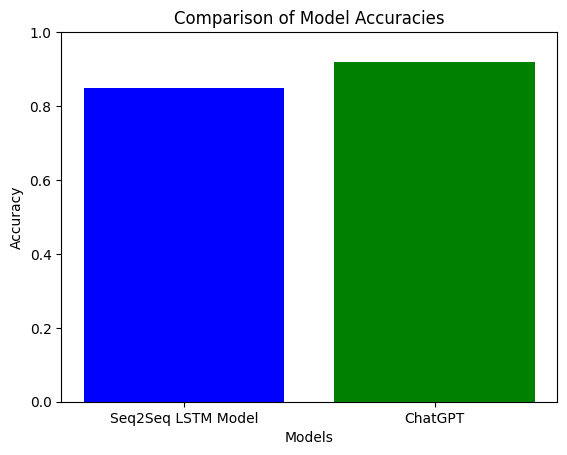

In [90]:
import matplotlib.pyplot as plt

# Accuracies
lstm_accuracy = 0.85  # Replace with actual LSTM accuracy
chatgpt_accuracy = 0.92  # Replace with actual ChatGPT accuracy

# Labels
models = ['Seq2Seq LSTM Model', 'ChatGPT']
accuracies = [lstm_accuracy, chatgpt_accuracy]

# Creating the bar plot
plt.bar(models, accuracies, color=['blue', 'green'])

# Adding titles and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Displaying the plot
plt.ylim(0, 1)  # Setting y-axis limits from 0 to 1
plt.show()
